In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette())

import pandas as pd
import pickle
from tqdm.notebook import tqdm
from plotnine import *

from mcmcmd.samplers import *
from mcmcmd.tests import *

from statsmodels.tsa.stattools import acf


In [2]:
class gandy_scott_sampler(model_sampler):
    def __init__(self, **kwargs):
        self._N = 1
        self._sigma = 10
        self._sigma_epsilon = onp.sqrt(0.1)
        super().__init__(**kwargs)
                     
        assert self._sigma > 0
        assert self._sigma_epsilon > 0
                     
        pass
    

    @property
    def sample_dim(self):
        return self._N + 2

    @property
    def theta_indices(self):
        return onp.arange(self._N, self.sample_dim)


    def drawPrior(self, rng=None):
        if rng is None:
            rng = self._rng_s

        self._theta_1 = rng.normal(loc=0, scale=self._sigma)
        self._theta_2 = rng.normal(loc=0, scale=self._sigma)
                     
        return onp.array([self._theta_1, self._theta_2])

    def drawLikelihood(self, rng=None):
        if rng is None:
            rng = self._rng_s

        self._y = rng.normal(loc=self._theta_1 + self._theta_2,
                           scale=self._sigma_epsilon, size = (self._N, 1))
        
        return self._y.flatten()

    def drawPosterior(self, rng=None):
        if rng is None:
            rng = self._rng_s
        
        var_post = 1/(1/self._sigma**2 + self._N/self._sigma_epsilon**2)
        
        # Random scan for reversibility
        if rng.choice(2) == 1:
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
        else:
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
        
        return onp.array([self._theta_1, self._theta_2]) 

    def test_functions(self, samples):
        assert samples.shape[1] == self.sample_dim
        
        g = onp.hstack([samples[:, self.theta_indices[0]].reshape(-1,1), 
                       (samples[:, self.theta_indices[0]]**2).reshape(-1,1), 
                       (samples[:, self.theta_indices[0]]*samples[:, self.theta_indices[1]]).reshape(-1,1), 
                       onp.exp(norm.logpdf(x=samples[:, self.theta_indices], scale=self._sigma).sum(1)).reshape(-1,1),
                       onp.exp(norm.logpdf(x=(samples[:, :self._N]).reshape(-1,1), loc=(samples[:, self.theta_indices[0]]+samples[:, self.theta_indices[1]]).reshape(-1,1), scale=self._sigma_epsilon).sum(1)).reshape(-1,1)
                      ])
        return g
    
# Incorrect expectation
class gandy_scott_sampler_error_1(gandy_scott_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = self._rng_s
        
        var_post = 1/(1/self._sigma**2 + self._N/self._sigma_epsilon**2)
        
        # Random scan for reversibility
        if rng.choice(2) == 1:
            exp_post_1 = var_post * ((self._y+self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
            exp_post_2 = var_post * ((self._y+self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
        else:
            exp_post_2 = var_post * ((self._y+self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
            exp_post_1 = var_post * ((self._y+self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
        
        return onp.array([self._theta_1, self._theta_2]) 

# Incorrect variance
class gandy_scott_sampler_error_2(gandy_scott_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = self._rng_s
        
        var_post = 1/(1/self._sigma + self._N/self._sigma_epsilon)
        
        # Random scan for reversibility
        if rng.choice(2) == 1:
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
        else:
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
        
        return onp.array([self._theta_1, self._theta_2]) 

# Incorrect truncation?
class gandy_scott_sampler_error_3(gandy_scott_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = self._rng_s
        
        var_post = 1/(1/self._sigma**2 + self._N/self._sigma_epsilon**2)
        
        sign_1 = rng.choice([1, -1])
        sign_2 = rng.choice([1, -1])
        
        # Random scan for reversibility
        if rng.choice(2) == 1:
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = sign_1 * onp.abs(rng.normal(scale=onp.sqrt(var_post))) + exp_post_1
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = sign_2 * onp.abs(rng.normal(scale=onp.sqrt(var_post))) + exp_post_2
        else:
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = sign_2 * onp.abs(rng.normal(scale=onp.sqrt(var_post))) + exp_post_2
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = sign_1 * onp.abs(rng.normal(scale=onp.sqrt(var_post))) + exp_post_1
        
        return onp.array([self._theta_1, self._theta_2]) 

# Random error
class gandy_scott_sampler_error_4(gandy_scott_sampler):
    def __init__(self, error_rate, **kwargs):
        super().__init__(**kwargs)
                     
        assert self._sigma > 0
        assert self._sigma_epsilon > 0
        assert self._error_rate >= 0 and self._error_rate <= 1
        
        pass
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = self._rng_s
                
        # Randomly make the variance small
        if rng.uniform() <= self._error_rate:
            var_post = 1/(1/self._sigma**2 + self._N/self._sigma_epsilon)
        else:
            var_post = 1/(1/self._sigma**2 + self._N/self._sigma_epsilon**2) # Correct

        
        # Random scan for reversibility
        if rng.choice(2) == 1:
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
        else:
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
        
        return onp.array([self._theta_1, self._theta_2]) 

# Setup

The model is
\begin{align}
    y &= \theta_1 + \theta_2 + \epsilon \\
    \theta_i &\sim \mathcal{N}(0, \sigma^2), i=1,2 \\
    \epsilon &\sim \mathcal{N}(0, \sigma_\epsilon^2)
\end{align}

The posterior distributions of $\theta_1$ and $\theta_2$ are also normal

\begin{align}
\theta_{i} \sim \mathcal{N}(
\frac{\sigma^{2}}{\sigma_{\epsilon}^{2}+\sigma^{2}}\left(y-\theta_{j}\right)
, \frac{1}{\frac{1}{\sigma_{\epsilon}^{2}}+\frac{1}{\sigma^{2}}})
\end{align}

# Experiments

In [ ]:
num_trials = 20

lst_experiments = [gandy_scott_sampler(), gandy_scott_sampler_error_1(), gandy_scott_sampler_error_2()]#, gandy_scott_sampler_error_3()]
lst_tests = ['mmd', 'rank', 'ks']
lst_sample_size = [200, 300, 400, 500]

alpha = 1e-2
k = 3
Delta = 1

df_results = pd.DataFrame(index=onp.arange(0, len(lst_experiments)*len(lst_tests)*len(lst_sample_size)), columns=('experiment', 'test_type', 'sample_size', 'result'))

i = 0
for exper in tqdm(lst_experiments):
    for test_type in tqdm(lst_tests):
        for n in (lst_sample_size):
            rej_rate = 0
            for _ in (range(num_trials)):
                f_test = lambda n: f_test_sequential(sample_size=n, model=exper, test_type=test_type)
                rej_rate += int(sequential_test(f_test, n, alpha, k, Delta))
            rej_rate /= num_trials
            df_results.loc[i] = [type(exper).__name__, test_type, n, rej_rate]
            i += 1

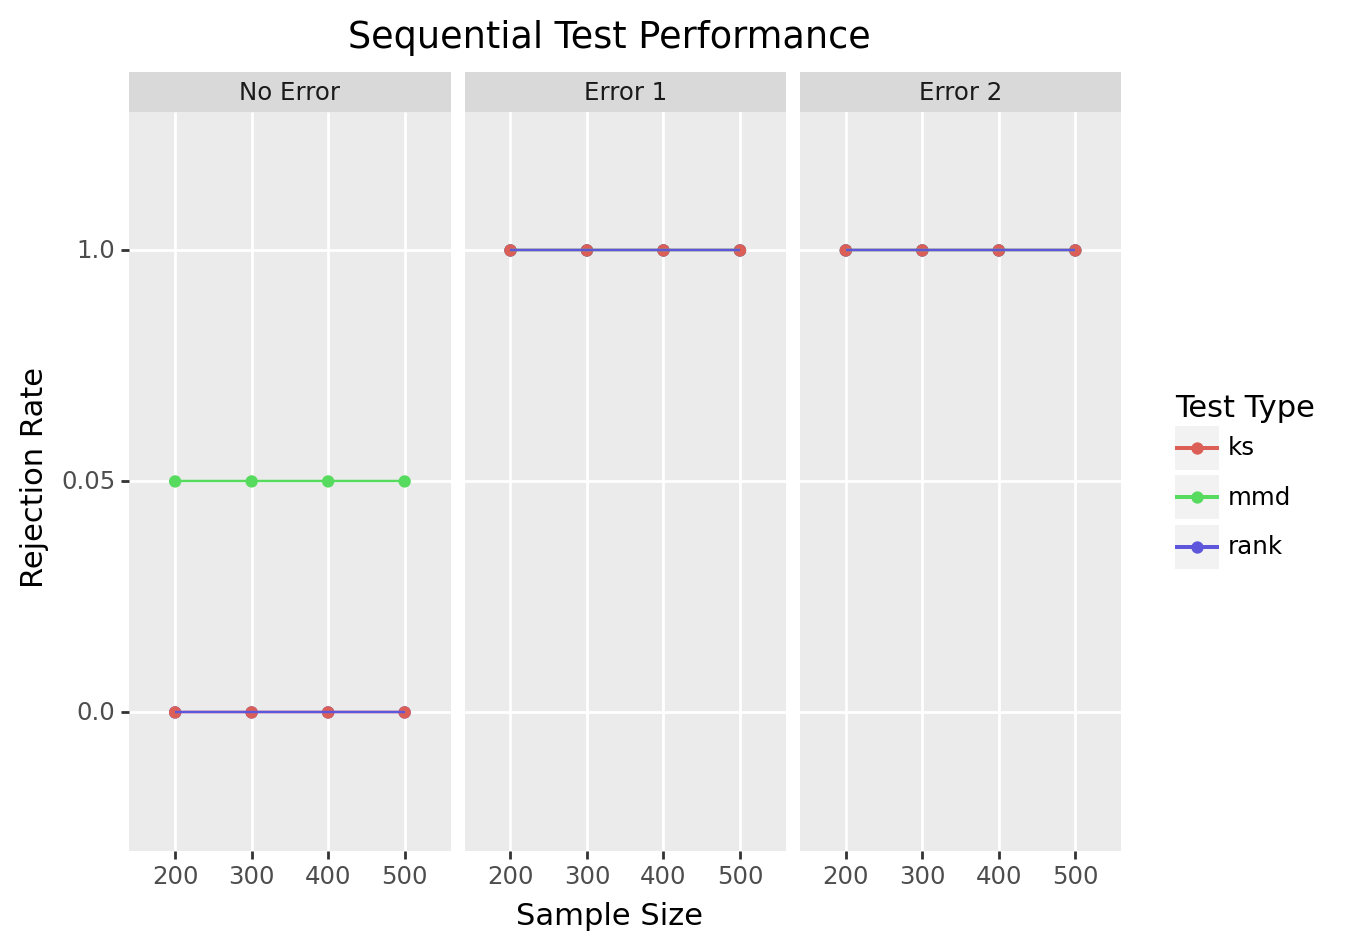

<ggplot: (-9223363265037318414)>

In [8]:
def exp_label(x):
    if 'error_1' in x:
        return 'Error 1'
    elif 'error_2' in x:
        return 'Error 2'
    else:
        return 'No Error'

ggplot(df_results, aes(color='test_type', group='test_type', x='sample_size',  y='result')) + \
    geom_point() + geom_line() + \
    facet_grid('~experiment', labeller = exp_label) + \
    labs(x='Sample Size', y='Rejection Rate', title='Sequential Test Performance', color='Test Type')

# Test random error

In [ ]:
num_trials = 20

lst_experiments = [gandy_scott_sampler_error_4(error_rate=0), gandy_scott_sampler_error_4(error_rate=0.01)]
lst_tests = ['mmd', 'rank', 'ks']
lst_sample_size = [3000, 4000]

alpha = 1e-2
k = 3
Delta = 1

df_results = pd.DataFrame(index=onp.arange(0, len(lst_experiments)*len(lst_tests)*len(lst_sample_size)), columns=('error_rate', 'test_type', 'sample_size', 'result'))

i = 0
for exper in tqdm(lst_experiments):
    for test_type in tqdm(lst_tests):
        for n in (lst_sample_size):
            rej_rate = 0
            for _ in (range(num_trials)):
                f_test = lambda n: f_test_sequential(sample_size=n, model=exper, test_type=test_type)
                rej_rate += int(sequential_test(f_test, n, alpha, k, Delta))
            rej_rate /= num_trials
            df_results.loc[i] = [exper._error_rate, test_type, n, rej_rate]
            i += 1

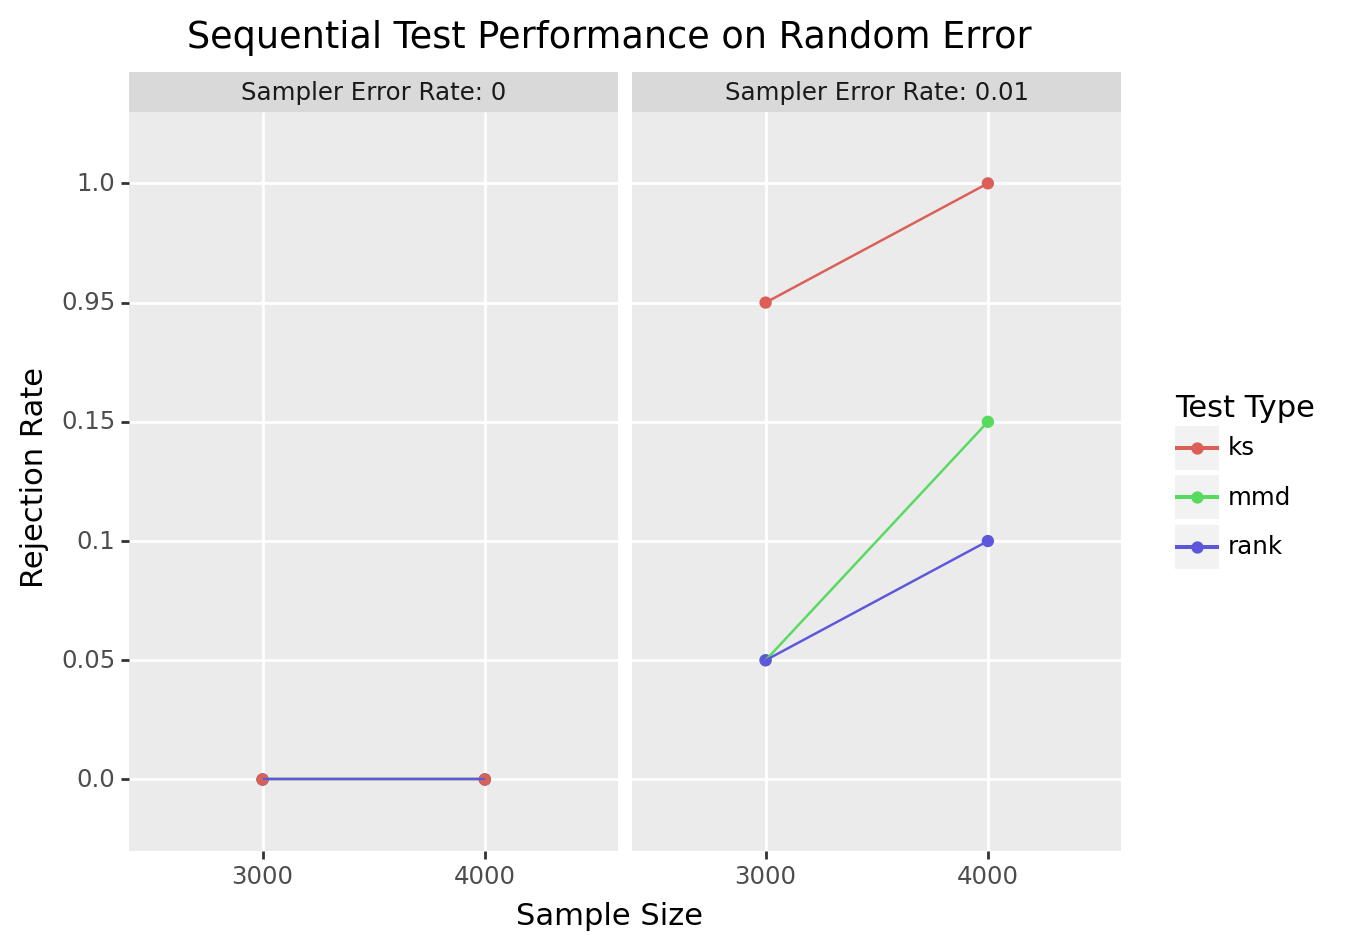

<ggplot: (8786715467426)>

In [102]:
def exp_label(x):
    return f'Sampler Error Rate: {x}'

ggplot(df_results, aes(color='test_type', group='test_type', x='sample_size',  y='result')) + \
    geom_point() + geom_line() + \
    facet_grid('~sampler_error_rate', labeller = exp_label) + \
    labs(x='Sample Size', y='Rejection Rate', title='Sequential Test Performance on Random Error', color='Test Type')